# Project Overview

**Objective**<br>
The main objective of this project is to perform Sentiment Analysis on customer reviews on the Brazilian E-Commerce platform [Olist](https://olist.com/pt-br/) using Natural Language Processing ('NLP'). This is crucial for sellers to understand their customers' perception towards their products and services, to drive customer engagement and identify areas for improvement in their business.<br><br>
**Data**<br>
The datasets used here are **[The Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/olistbr/brazilian-ecommerce)**. The dataset contains information of 100k orders from 2016 to 2018 such as order status, price, payment and freight performance to customer location, product attributes, etc.<br><br>
The focal point here would be the **reviews written by the customers** in Brazilian (Portugese). Once the customer receives the product, or when the estimated delivery date is due (whether customer receives the product or not), the customer gets a satisfaction survey by email to describe the purchase experience and write down some comments.

# Problem Statement & Strategy

**Problem Statement**<br>
What is the sentiment of the review or comment provided by the customers? Is it positive or negative?<br>
Olist and the sellers would need to go through each and every review to determine if they are positive or negative, and monitor any negative responses to help identify issues such as late deliveries, poor quality and fake products.<br><br>
**Strategy**<br>
To use machine learning ("ML") to **classify** the sentiment of the reviews. The expected outcome would be given a customer's review, it is either a positive review (Sentimento Positivo) or a negative review (Sentimento Negativo).<br><br>
Since this is a classification problem, the target variable - an indicator of whether it is a positive review or not is required. Unfortunately, the review dataset provided by Olist is not labelled. Due to time constraint, the reviews were not manually assessed to label them, and therefore it is assumed that the review is positive if the review score is 4 or 5; and the review is negative if the review score is 1, 2 or 3. Nevertheless, this assumption is reasonable as customers would tend to write positive review given a high score (4 or 5).<br><br>
In terms of explanatory variables, there are two types of important features to consider during feature extraction:
- Features related to the review message as a whole e.g., word count, whether entire review is capitalized etc.
- Features extracted from the words used, using techniques such as tokenization and vectorization (bag of words & TF-IDF) which will be explained in greater details below during data preparation.<br>

Although the output of this project is a web app that classifies the sentiment of the input review message in real-time, the Extract, Transform & Load ("ETL") and ML pipelines can be applied on Olist platform as a value-adding service to the sellers compared to other Brazilian E-Commerce platforms such as Mercado Livre and Americanas.  

# Metrics

There are 4 main types of metrics to evaluate the classification models:
- Accuracy<br>
It measures the proportion of predictions made that are correct and serves as the base measure. The formula is (TP + TN)/(TP + TN + FP + FN).<br>
- Precision<br>
It measures the proportion of positive predictions made that are correct. The formula is TP/(TP + FP).<br>
- Recall<br>
It measures the proportion of positive cases that are predicted correctly. The formula is TP(TP + FN).<br>
- F1-Score<br>
It provides the "harmonic mean" that combines both Precision and Recall measures in a balanced way. It requires both measures to increase to result in a high F1-score. The formula is (2 * Recall * Precision)/(Recall + Precision)<br>

Note that "Correct" predictions here refer to True Positives ("TP") and True Negatives ("TN"). TP refer to messages with Positive Sentiment being correctly classified as Positive Sentiment, and likewise for TN in which review messages with Negative Sentiments being correctly classified as Negative Sentiment. False Positives ("FP") refer to messages with Negative Sentiments that were falsely classified as Positive Sentiment by the model, and likewise for False Negatives ("FN") in which messages with Positive Sentiment were falsely classified as Negative Sentiment. 

# Import Libraries

In [1]:
# Import essential libraries
import os
import time
import json
import random
import pandas as pd
import numpy as np
import re
import pickle
from datetime import datetime

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import nltk libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download(['punkt', 'wordnet', 'stopwords', 'averaged_perceptron_tagger'])

# Import SQLite libraries
from sqlalchemy import create_engine

# Import sklearn libraries
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fucheng.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fucheng.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fucheng.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fucheng.liew\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Settings

In [2]:
# To view all generated results
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Widen the Jupyter Notebook as much as possible
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

# Import Data

In [3]:
# Setting the directories
cd = os.getcwd()
data_dir = cd + '\\data'

# Import data
review_df = pd.read_csv(data_dir + '\\olist_order_reviews_dataset.csv')
review_df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
# View dataset info
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [5]:
# View any missing values
review_df.isnull().sum()

# There are missing review or comment messages
# These rows with missing reviews need to be removed as no features can be extracted

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [6]:
# Import other key features such as product category and location to discover more about the reviews
order_df = pd.read_csv(data_dir + '\\olist_orders_dataset.csv') # Includes data on all the orders made
order_item_df = pd.read_csv(data_dir + '\\olist_order_items_dataset.csv') # Includes data about the items purchased within each order
prod_df = pd.read_csv(data_dir + '\\olist_products_dataset.csv') # Includes data about the products sold by Olist
prod_trans_df = pd.read_csv(data_dir + '\\product_category_name_translation.csv') # Translates the productcategoryname to english.
cust_df = pd.read_csv(data_dir + '\\olist_customers_dataset.csv') # Includes data about the customer and its location

# Show samples, dataset info and missing values info
df_list = [order_df, order_item_df, prod_df, prod_trans_df, cust_df]
for df_ in df_list:
    # Show samples
    print(df_.head())
    print('\n')
    
    # Show dataset info
    print(df_.info())
    print('\n')
    
    # Show missing values info
    print(df_.isnull().sum())
    print('\n')

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08

# Data Cleaning

In [7]:
# Keep key columns
df = review_df[['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message']]

# Remove missing reviews from review dataset
df = df[~df['review_comment_message'].isnull()]
len(df) # Around 41k reviews remain

40977

In [8]:
# Check for any duplicates
print(f'No. of duplicates based on all columns:{len(df[df.duplicated()])}')
                                                
# Check for any duplicates based on review_id
print(f'No. of duplicates based on all columns:{len(df[df.duplicated(subset="review_id")])}')

No. of duplicates based on all columns:0
No. of duplicates based on all columns:309


In [9]:
# View samples of duplicated review_id
df[df.duplicated(subset='review_id')].head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message
3317,3242cc306a9218d0377831e175d62fbf,9c5bfba7de6a4abbb6ba0baab78d1622,5,NaN,Ótimo
5719,308316408775d1600dad81bd3184556d,3fe4dbcdb046a475dbf25463c1ca78bd,5,NaN,Ajudem a rastrear uma das 3 prateleiras que fa...
7213,8ee90ac383cf825bb7f4756130d4e74a,75d5d3d16567a27eefc5752aeb063072,5,NaN,recomendo
9013,03a6a25db577d0689440933055111897,3fde8b7313af6b37b84b5c7594d7add0,5,NaN,Muito Bom! Gostei Bastante! Tecido Ótimo! Aten...
9387,7168439a7228c5684a494116c1c8da5f,d191ac7a9642a12d39419f26f43f800c,5,recomendo,"embalagem apropriada, entregue dentro do prazo"
10852,1c0c84f0e3132c3af0a17f0aa4987879,60b3fa9424e97cd3b6b95ca799d511c6,1,NaN,"Muito ruim a qualidade, as bordas do desenho v..."
11623,1708c3eec64152cb52fe56bb3abcf257,5dc05f32211efb743fde17f226adfb6b,4,NaN,Produto correspondeu as discrições
13878,5d1f78d752c653e019bd07cc48106300,5239a1d5badf5276845d8c71dbeb8fc9,5,NaN,otimo de se comprar
14206,1f5aa5d7c3ee7895e4d223797b5a5f2d,17df2cc060680fc1712991499b645cd2,5,NaN,Tudo ocorreu de forma eficiente
15215,5fbdc041e0938773613c1a6fbbf7b62a,75df014e897510b97edbb6261ef40f82,5,NaN,"Produto original, entrega rápida e bom preço!!!"


In [10]:
# View dataset of first 2 samples
df[df['review_id'].isin(['3242cc306a9218d0377831e175d62fbf', '308316408775d1600dad81bd3184556d'])]

# The review_id has duplicates due to the same review for multiple products ordered

,review_id,order_id,review_score,review_comment_title,review_comment_message
1009,3242cc306a9218d0377831e175d62fbf,711246846695fa895c1776f0ddc30b20,5,NaN,Ótimo
3317,3242cc306a9218d0377831e175d62fbf,9c5bfba7de6a4abbb6ba0baab78d1622,5,NaN,Ótimo
4545,308316408775d1600dad81bd3184556d,27e5ed2ecefbe0bcc9ae0c9b26b763c3,5,NaN,Ajudem a rastrear uma das 3 prateleiras que fa...
5719,308316408775d1600dad81bd3184556d,3fe4dbcdb046a475dbf25463c1ca78bd,5,NaN,Ajudem a rastrear uma das 3 prateleiras que fa...
53661,308316408775d1600dad81bd3184556d,8b3c2785144e72ccba9b0213f0f1cd1e,5,NaN,Ajudem a rastrear uma das 3 prateleiras que fa...


In [11]:
# Check for any duplicates based on review_id and review_comment_message
len(df[df.duplicated(subset=['review_id', 'review_comment_message'])])

# This duplicate count here is same as that based on review_id
# This implies that the same review message is applied to multiple product items within the same purchase

309

In [12]:
# Remove duplicates
df.drop_duplicates(subset=['review_id', 'review_comment_message'], inplace=True)
print(f'Row count after removing duplicates:{len(df)}')

# View data
df.head()

Row count after removing duplicates:40668


,review_id,order_id,review_score,review_comment_title,review_comment_message
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes..."


In [13]:
# Filter key columns from other datasets
order_df = order_df[['order_id', 'customer_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']]
order_item_df = order_item_df[['order_id', 'product_id']]
prod_df = prod_df[['product_id', 'product_category_name']]
cust_df = cust_df[['customer_id', 'customer_city', 'customer_state']]

# List each dataset and its key ID for data merging
df_list_updated = [order_df, order_item_df, prod_df, prod_trans_df, cust_df]
df_key_id_list = ['order_id', 'order_id', 'product_id', 'product_category_name', 'customer_id']

# Remove duplicates and merge with other datasets to extract key features
print(len(df)) # Get dataset row count before merging to check for any duplicates

i = 0 # Set counter to loop through the list
for df_ in df_list_updated:
    
    # Get respective key id from df_key_id_list
    id_ = df_key_id_list[i]
    print(id_)
    
    # Remove duplicates before merging
    print('Merge with df using ' + id_ + ':')
    print('\n')
    df_.drop_duplicates(subset=[id_], inplace=True)
    df = df.merge(df_, on=id_, how='left')
    
    i += 1 # Update counter

# The dataset row count should remain unchanged after merging, indicating the dataset shape remained intact
print(len(df)) 

# View data
df.head()

40668
order_id
Merge with df using order_id:




<ipython-input-13-a73d2bf82844>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.drop_duplicates(subset=[id_], inplace=True)


order_id
Merge with df using order_id:


product_id
Merge with df using product_id:


product_category_name
Merge with df using product_category_name:


customer_id
Merge with df using customer_id:


40668


,review_id,order_id,review_score,review_comment_title,review_comment_message,customer_id,order_delivered_customer_date,order_estimated_delivery_date,product_id,product_category_name,product_category_name_english,customer_city,customer_state
0,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,de6dff97e5f1ba84a3cd9a3bc97df5f6,2017-04-20 09:08:35,2017-05-10 00:00:00,52c80cedd4e90108bf4fa6a206ef6b03,ferramentas_jardim,garden_tools,gravatal,SC
1,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,5986b333ca0d44534a156a52a8e33a83,2018-02-28 16:33:35,2018-03-09 00:00:00,3880d25d502b15b1de6fddc42ad1d67a,esporte_lazer,sports_leisure,curitibanos,SC
2,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,a5224bdc7685fd39cd7a23404415493d,2018-05-21 17:52:12,2018-06-06 00:00:00,61a4100ccd6d9c4c808a1fd954ddb8ad,eletroportateis,small_appliances,sao paulo,SP
3,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,NaN,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",8ebbeb09e94d1e789142983f73faa9cd,2018-02-15 19:16:54,2018-02-26 00:00:00,acffe5d7cd56e6b564cf6841486644ff,beleza_saude,health_beauty,cotia,SP
4,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,Super recomendo,"Vendedor confiável, produto ok e entrega antes...",659ded3e9b43aaf51cf9586d03033b46,2018-05-22 14:58:47,2018-06-07 00:00:00,6871a3c157d6f51697e887f3c3598479,informatica_acessorios,computers_accessories,guarulhos,SP


In [14]:
# View any missing values
df.isnull().sum()

review_id                            0
order_id                             0
review_score                         0
review_comment_title             30870
review_comment_message               0
customer_id                          0
order_delivered_customer_date     1846
order_estimated_delivery_date        0
product_id                         504
product_category_name             1109
product_category_name_english     1119
customer_city                        0
customer_state                       0
dtype: int64

# Explatory Data Analysis (EDA)

### Late Delivery Indicator

0    0.862472
1    0.137528
Name: delivery_late_ind, dtype: float64


,review_id,order_id,review_score,review_comment_title,review_comment_message,customer_id,order_delivered_customer_date,order_estimated_delivery_date,product_id,product_category_name,product_category_name_english,customer_city,customer_state,delivery_late_ind
5,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,NaN,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",db13a417a95ad304e9674468c17ade85,2018-02-21 01:25:41,2018-01-17,4413a608a42bd21bbf9d5abbd58c249a,cool_stuff,cool_stuff,paty do alferes,RJ,1
6,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,e545e697bb9d1b81e0a702121d4e94d5,NaT,2018-08-13,55a1e3d39ace9c0b217f6c30b04d43c0,malas_acessorios,luggage_accessories,guarulhos,SP,1
12,58044bca115705a48fe0e00a21390c54,68e55ca79d04a79f20d4bfc0146f4b66,1,NaN,Sempre compro pela Internet e a entrega ocorre...,30e6e854c81fa16f46a5d7f3ab025e6f,2018-04-11 02:12:46,2018-04-06,bfc0d01be79d9038c7720f983bf954e0,relogios_presentes,watches_gifts,esteio,RS,1
17,9fd59cd04b42f600df9f25e54082a8d1,3c314f50bc654f3c4e317b055681dff9,1,NaN,Nada de chegar o meu pedido.,c17d38e818f10c91ebcd036bc835a648,2017-04-24 09:18:11,2017-04-19,56b83ac081e4e6ea5f87323b4e46e85c,cama_mesa_banho,bed_bath_table,corrente,PI,1
29,6d06808638ec0701bccd70bc8d462c28,97d2f8fe76f2f253b8291e17b5383884,1,NaN,O produto não chegou no prazo estipulado e cau...,5458c93e0db88f9b885bc7dbc3bfa2a3,NaT,2016-12-07,a8255c87078b4bd9bc05fe7290ca5c25,automotivo,auto,cuiaba,MT,1


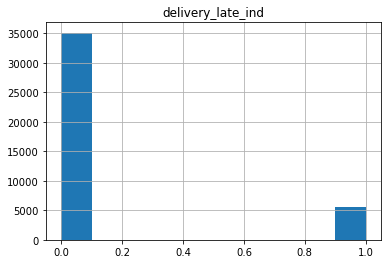

In [15]:
# Determine if the delivery was late or never arrived (missing order_delivered_customer_date is assumed to never arrive)
date_vars = ['order_estimated_delivery_date', 'order_delivered_customer_date']
df[date_vars] = df[date_vars].astype(np.datetime64)
df['delivery_late_ind'] = 0
df.loc[(df['order_delivered_customer_date'].isnull()) | 
       (df['order_delivered_customer_date'] > df['order_estimated_delivery_date'] + pd.Timedelta(days=1)), 'delivery_late_ind'] = 1

# View distribution
df.hist(column='delivery_late_ind')
print(df['delivery_late_ind'].value_counts(normalize=True).sort_index())

# View data samples
df[df['delivery_late_ind'] > 0].head() 

# First review message is all capitalized, expressing dissatisfaction frustratingly.
# Discovering whether entire review message is capitalized might provide insights towards the sentiments.
# There are around 14% of reviews with late deliveries.
# It may be a redundant feature in identifying sentiments as intuitively,
# reviews would tend to mention "entrega tardia" or "late delivery".
# This would be picked up by the word vectorizer later.

### Capitalized Review Message Indicator

0    0.963829
1    0.036171
Name: capitalize_ind, dtype: float64


,review_id,order_id,review_score,review_comment_title,review_comment_message,customer_id,order_delivered_customer_date,order_estimated_delivery_date,product_id,product_category_name,product_category_name_english,customer_city,customer_state,delivery_late_ind,capitalize_ind
5,9314d6f9799f5bfba510cc7bcd468c01,0dacf04c5ad59fd5a0cc1faa07c34e39,2,NaN,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI E...",db13a417a95ad304e9674468c17ade85,2018-02-21 01:25:41,2018-01-17,4413a608a42bd21bbf9d5abbd58c249a,cool_stuff,cool_stuff,paty do alferes,RJ,1,1
42,1692078634b63c7f25aa90ee746ec498,5bc4e94aef2841f392fb6fe7ceef69b6,5,OTIMO,OK RECOMENDO,017f022018ad01373771ddfd46eb5dc6,2018-05-22 17:22:53,2018-06-01,2770305847be150f16eb0b25fa7c171b,informatica_acessorios,computers_accessories,recife,PE,0,1
56,3f6d9482c57cdb5fc7012f7b9b5ed4c5,2a3251c95a3d5c57ed230021faa588a0,5,NaN,OTIMA,d59025c30cdd8d747f2acfa5fdc2925a,2018-04-18 23:28:43,2018-04-27,56c221c4c1a4a98293895c4563cdc6bf,construcao_ferramentas_seguranca,construction_tools_safety,joao pessoa,PB,0,1
59,ef8ae544c432bb1053ba5990bd0d6227,e18ebd6286697a3f0f6fe267d8286cb2,1,NaN,EU NÃO RECEBI O PRODUTO E CONSTA NO SISTEMA QU...,de3488839c20b6109821b6a1af9818df,2018-01-11 23:16:14,2018-02-01,78efe838c04bbc568be034082200ac20,moveis_decoracao,furniture_decor,maua,SP,0,1
64,d8f61c7fcd172785563a65cd65a8cea8,cf34fe44babb9fd001a001acfa43cabf,5,NaN,OK,fe082a45e6e64db9443e39ef7e3d415a,2017-11-18 09:21:44,2017-11-24,40540b68d7fd077e46c33308fb59c2f5,cama_mesa_banho,bed_bath_table,sao paulo,SP,0,1


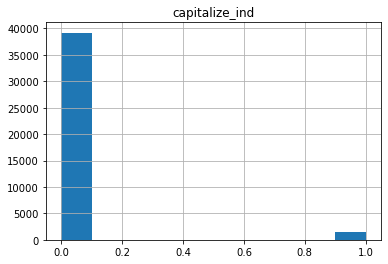

In [16]:
# Determine if entire review_comment_message is capitalized
df['capitalize_ind'] = 0
df.loc[df['review_comment_message'] == df['review_comment_message'].str.upper(), 'capitalize_ind'] = 1

# View distribution
df.hist(column='capitalize_ind')
print(df['capitalize_ind'].value_counts(normalize=True).sort_index())

# View data samples
df[df['capitalize_ind'] > 0].head()

# Only a small % of reviews are fully capitalized, may not be a good feature in identifying sentiments.

### Review Message Word Count

,review_id,order_id,review_score,review_comment_title,review_comment_message,customer_id,order_delivered_customer_date,order_estimated_delivery_date,product_id,product_category_name,product_category_name_english,customer_city,customer_state,delivery_late_ind,capitalize_ind,review_message_length
4176,007c08c01178c42ff829560cc24dd0d6,d9064a51ed213dcd0cfe59a9039ec458,5,NaN,\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n,8c7a3139130cd3e36983e6f7626ccf6c,2017-11-17 22:56:37,2017-11-27,fc2351bcf24c714e5d21b44ad41198b7,bebes,baby,diadema,SP,0,1,0
4723,1fe9d2ee706fb28c431aa5d933245d45,81aa3cffc965f29788470b3e2550da67,5,Ótima,\r\n,5fb5fbe39b9e4109881ace8ec13c3e6a,2018-05-12 15:26:36,2018-05-18,e23ad0cd69c2d088fce8285de421f61d,pet_shop,pet_shop,campinas,SP,0,1,0
4895,479455dcf5c7b17c5025011776ac844e,d4c1356b86dcc8a86c603174ba27d9bc,5,NaN,\r\n\r\n,5bb44f6a01f1362e3eb39c521d1d1b08,2018-01-17 22:59:07,2018-01-30,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,furniture_decor,taubate,SP,0,1,0
4933,1ce11bd2d9c397e0b673035dcc533f5c,7a3f8080c604ded6519cd5b601f690b7,5,NaN,\r\n,804e210975d02fbfc866515639f30135,2018-05-30 13:07:50,2018-06-05,6ce07ff93c0dbafa9df5c10038e41287,cama_mesa_banho,bed_bath_table,lobato,PR,0,1,0
10864,b905a83cd40f67b08363261fc2d2dadb,cf65e1cf310d6860d96e2efaab1f5d75,5,NaN,\r\n,4bf0860a7a4807c9e9160cf4b6c2b33d,2017-08-21 17:57:43,2017-09-11,c71bf92cf123eb294304073fc1751bf3,esporte_lazer,sports_leisure,bento goncalves,RS,0,1,0


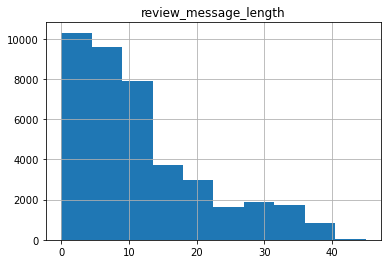

In [17]:
# Determine length of review_comment_message
df['review_message_length'] = df['review_comment_message'].apply(lambda x: len(x.split()))

# View distribution
df.hist(column='review_message_length')

# View data samples
df[df['review_message_length'] <= 0].head()

# To remove these non-empty messages with 0 word count.
# To remove "\r\n" from the reviews.

In [23]:
# Remove "\r\n"
df['review_comment_message'] = df['review_comment_message'].replace(r'\s+|\\n', '', regex=True) 

# Remove those with word count of 0
df = df[~df['review_comment_message'].isnull()]
df = df[df['review_comment_message'] != '']
print(f'No. of messages with word count of 0: {len(df[df["review_message_length"] <= 0])}')

# View data samples
df[df['review_message_length'] <= 1].head()

No. of messages with word count of 0: 0


,review_id,order_id,review_score,review_comment_title,review_comment_message,customer_id,order_delivered_customer_date,order_estimated_delivery_date,product_id,product_category_name,product_category_name_english,customer_city,customer_state,delivery_late_ind,capitalize_ind,review_message_length
6,373cbeecea8286a2b66c97b1b157ec46,583174fbe37d3d5f0d6661be3aad1786,1,Não chegou meu produto,Péssimo,e545e697bb9d1b81e0a702121d4e94d5,NaT,2018-08-13,55a1e3d39ace9c0b217f6c30b04d43c0,malas_acessorios,luggage_accessories,guarulhos,SP,1,0,1
23,3d94fd645cdaacc8c9f0dc0a2a1f5166,4d483bf690ca21bdc005df9b623673c7,5,NaN,boa,80a6a8b570864a52a54462d82b6fb51f,2017-03-20 10:32:31,2017-04-04,18d307d967bbf1300aa00b34f34c374c,beleza_saude,health_beauty,santana de parnaiba,SP,0,0,1
35,e29ab4a671400c41322e4855de633c6a,17b296b73ebefd6213299342b09f097f,5,NaN,Maravilha,4d31792c00baf91319f111857058ee80,2017-08-08 19:27:12,2017-08-11,f7f59e6186e10983a061ac7bdb3494d6,utilidades_domesticas,housewares,campinas,SP,0,0,1
40,436f71c9cc0c1aab7f51dc0cd0820516,c676e726f8a14a9527b41b9dc50ca1bc,5,NaN,Satisfeito,2ca78d68b23aa3531eb8c29f55194c4e,2017-11-21 21:07:03,2017-11-30,b694e2087c446e6905b08cd9360cfe45,cama_mesa_banho,bed_bath_table,campinas,SP,0,0,1
55,c422274e50e900b46fee429016c5458d,950bb159eea525ff8947b92c93b02f8e,3,NaN,Gostei,ff299a256be6affac0ae1207c1b4a9b8,2017-09-23 17:09:13,2017-09-27,86f2416d4670e4ea3ca5494d043d9f24,moveis_escritorio,office_furniture,carapicuiba,SP,0,0,1


## Product Categories

<AxesSubplot:ylabel='product_category_name_english'>

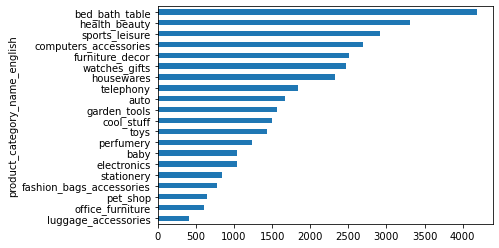

In [36]:
# View distribution (Top 20)
df.groupby('product_category_name_english')['review_comment_message'].count().sort_values().tail(20).plot(kind='barh')

## Customer Cities

<AxesSubplot:ylabel='customer_city'>

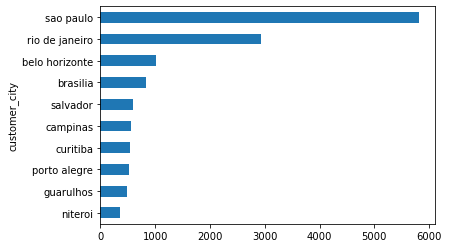

In [37]:
# View distribution
df.groupby('customer_city')['review_comment_message'].count().sort_values().tail(10).plot(kind='barh')

## Customer States

<AxesSubplot:ylabel='customer_state'>

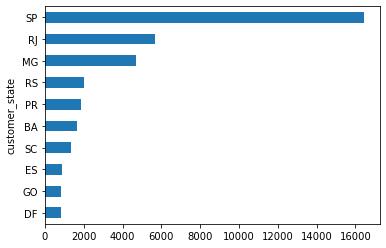

In [38]:
# View distribution
df.groupby('customer_state')['review_comment_message'].count().sort_values().tail(10).plot(kind='barh')

## Review Scores

<AxesSubplot:xlabel='review_score'>

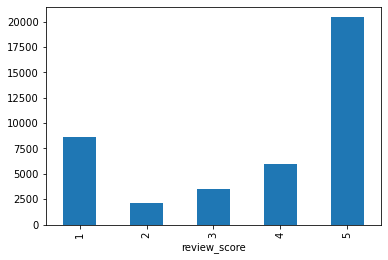

In [41]:
# View distribution
df.groupby('review_score')['review_comment_message'].count().sort_index().plot(kind='bar')

1    0.648483
0    0.351517
Name: positive_review_ind, dtype: float64


<AxesSubplot:xlabel='positive_review_ind'>

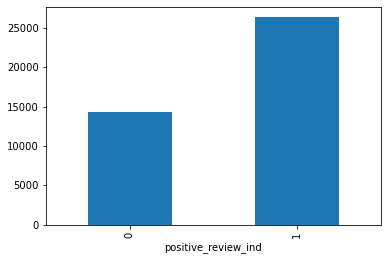

In [43]:
# Creating the response variable
df['positive_review_ind'] = 0
df.loc[df['review_score'] >= 4, 'positive_review_ind'] = 1

# View distribution
print(df['positive_review_ind'].value_counts(normalize=True))
df.groupby('positive_review_ind')['review_comment_message'].count().sort_index().plot(kind='bar')

## Breakdown of Attributes in terms of Review Scores

product_category_name_english
Review Count
AxesSubplot(0.125,0.125;0.775x0.755)


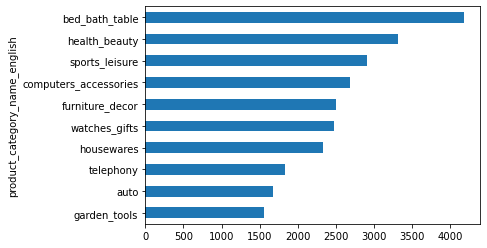

Average Positive Sentiment Mix
AxesSubplot(0.125,0.125;0.775x0.755)


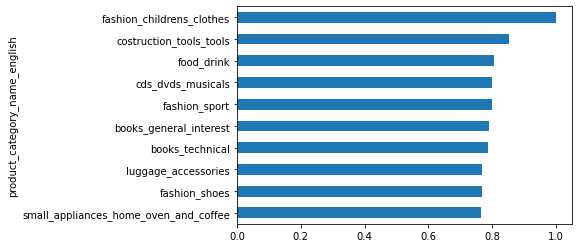

customer_city
Review Count
AxesSubplot(0.125,0.125;0.775x0.755)


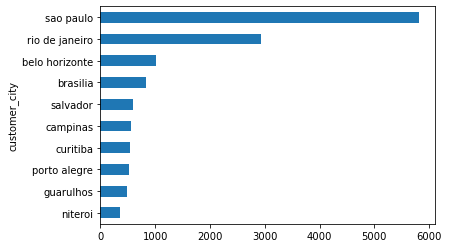

Average Positive Sentiment Mix
AxesSubplot(0.125,0.125;0.775x0.755)


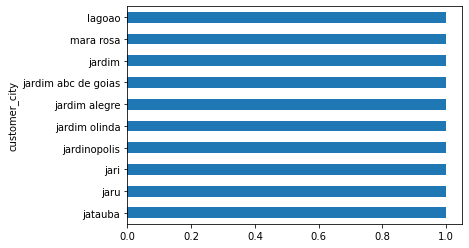

customer_state
Review Count
AxesSubplot(0.125,0.125;0.775x0.755)


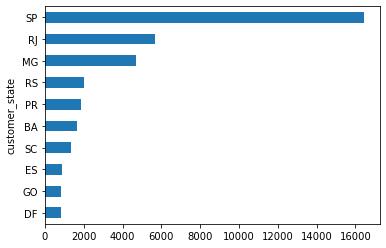

Average Positive Sentiment Mix
AxesSubplot(0.125,0.125;0.775x0.755)


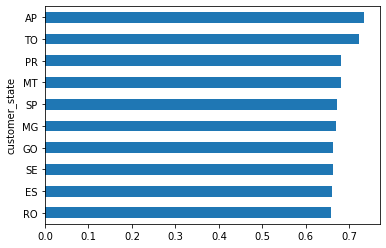

delivery_late_ind
Review Count
AxesSubplot(0.125,0.125;0.775x0.755)


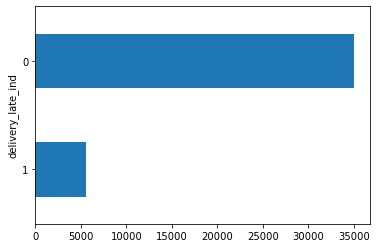

Average Positive Sentiment Mix
AxesSubplot(0.125,0.125;0.775x0.755)


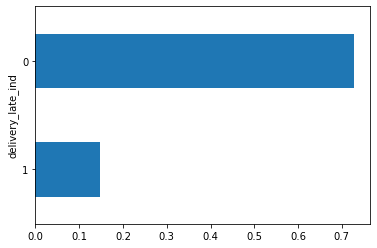

review_message_length
Review Count
AxesSubplot(0.125,0.125;0.775x0.755)


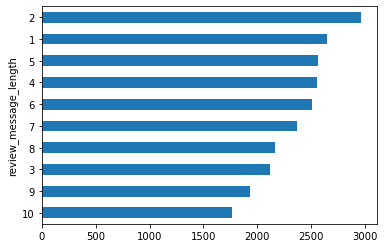

Average Positive Sentiment Mix
AxesSubplot(0.125,0.125;0.775x0.755)


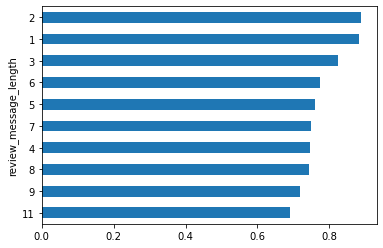

capitalize_ind
Review Count
AxesSubplot(0.125,0.125;0.775x0.755)


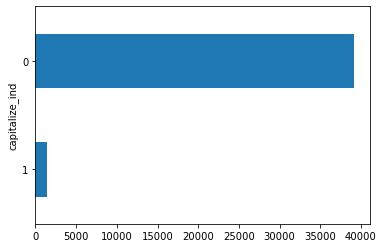

Average Positive Sentiment Mix
AxesSubplot(0.125,0.125;0.775x0.755)


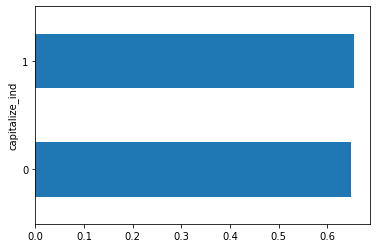

In [54]:
# List of attributes
attribute_list = ['product_category_name_english', 'customer_city', 'customer_state', 
                  'delivery_late_ind', 'review_message_length', 'capitalize_ind']

for att in attribute_list:
    
    # Show distribution
    print(att)
    print('Review Count')
    print(df.groupby(att)['positive_review_ind'].count().sort_values().tail(10).plot(kind='barh'))
    plt.show()
    
    print('Average Positive Sentiment Mix')
    print(df.groupby(att)['positive_review_ind'].mean().sort_values().tail(10).plot(kind='barh'))
    plt.show()
    
# From the charts below, the review message tends to be positive if:
# a. Review message is shorter
# b. Delivery is on time or earlier
# c. Smaller populated cities as top cities (with most review count) are nowhere on top 10 with most positive reviews

# Given that the only input would be the review text message itself
# Thus, the city and product category will not be focused
# However, these features will help enhance our understanding of the data

# Data Preparation

This section is focused on preparing the dataset based on the content of the comments itself, along with other relevant attributes disclosed above.

In [21]:
# Create the tokenizer function to extract tokens for Tfidf transformer after this
def tokenizer(text):
    # Remove punctuations 
    detected_punctuations = re.findall('[^a-zA-Z0-9]', text)
    for punctuation in detected_punctuations:
        text = text.replace(punctuation, ' ')
        
    # Remove words with single letters
    text = ' '.join([w for w in text.split() if len(w) > 1])
        
    # Tokenize the words
    tokens = word_tokenize(text)    
    
    # Lemmanitizer to reduce words to its stems
    lemmatizer = WordNetLemmatizer()

    # List of clean tokens
    clean_tokens = [lemmatizer.lemmatize(w).lower().strip() for w in tokens]
    
    # Remove stopwords in Portugese
    por_stopwords = stopwords.words('portuguese')
    for st in por_stopwords:
        if st in clean_tokens:
            clean_tokens.remove(st)
            
    return clean_tokens

Word cloud or bar charts of top 10 words for both sentiments

# Model Training

In [23]:
# Create the predictor and response datasets
X = df['review_comment_message']
y = df['positive_review_ind']

# Separate into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

In [24]:
# Based on attributes observed earlier, longer comments tend to associate with negative sentiments (lower review score)
class GetReviewLength(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_len = pd.Series(X).apply(lambda x: len(x.split()))
        return pd.DataFrame(X_len)

In [25]:
# Create ML pipeline - Random Forest
pipeline = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenizer)),
                ('tfidf', TfidfTransformer())
            ])),

            ('review_length', GetReviewLength())
        ])),

        ('clf', RandomForestClassifier(n_jobs=-1, verbose=2)) # Use all processors
    ])

# Train the model using grid search
pipeline.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100building tree 4 of 100


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100

building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.6s


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenizer at 0x0000021351B8D8B0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('review_length',
                                                 GetReviewLength())])),
                ('clf', RandomForestClassifier(n_jobs=-1, verbose=2))])

In [26]:
# Create ML pipeline - AdaBoost
pipeline2 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenizer)),
                ('tfidf', TfidfTransformer())
            ])),

            ('review_length', GetReviewLength())
        ])),

        ('clf', AdaBoostClassifier())
    ])

# Train the model using grid search
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenizer at 0x0000021351B8D8B0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('review_length',
                                                 GetReviewLength())])),
                ('clf', AdaBoostClassifier())])

In [28]:
# Create ML pipeline - Gradient Boosting
pipeline3 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenizer)),
                ('tfidf', TfidfTransformer())
            ])),

            ('review_length', GetReviewLength())
        ])),

        ('clf', GradientBoostingClassifier(verbose=2))
    ])

# Train the model using grid search
pipeline3.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2512           52.10s
         2           1.2102           51.36s
         3           1.1782           46.57s
         4           1.1496           44.63s
         5           1.1250           42.66s
         6           1.1051           41.51s
         7           1.0866           40.15s
         8           1.0714           39.10s
         9           1.0554           38.32s
        10           1.0410           38.05s
        11           1.0289           37.21s
        12           1.0157           36.56s
        13           1.0062           35.83s
        14           0.9963           35.24s
        15           0.9851           34.73s
        16           0.9753           34.00s
        17           0.9670           33.50s
        18           0.9598           33.03s
        19           0.9521           32.53s
        20           0.9459           32.01s
        21           0.9395           31.45s
        2

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenizer at 0x0000021351B8D8B0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('review_length',
                                                 GetReviewLength())])),
                ('clf', GradientBoostingClassifier(verbose=2))])

In [33]:
# Create ML pipeline - Neural Network
pipeline4 = Pipeline([
        ('features', FeatureUnion([

            ('text_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenizer)),
                ('tfidf', TfidfTransformer())
            ])),

            ('review_length', GetReviewLength())
        ])),

        ('clf', MLPClassifier(verbose=True))
    ])

# Train the model using grid search
pipeline4.fit(X_train, y_train)

Iteration 1, loss = 0.46827144
Iteration 2, loss = 0.29535110
Iteration 3, loss = 0.25586749
Iteration 4, loss = 0.23336080
Iteration 5, loss = 0.21872221
Iteration 6, loss = 0.20711621
Iteration 7, loss = 0.19723907
Iteration 8, loss = 0.18996318
Iteration 9, loss = 0.18353546
Iteration 10, loss = 0.17786924
Iteration 11, loss = 0.17286173
Iteration 12, loss = 0.17016895
Iteration 13, loss = 0.16646619
Iteration 14, loss = 0.16284918
Iteration 15, loss = 0.15871599
Iteration 16, loss = 0.15720155
Iteration 17, loss = 0.15458850
Iteration 18, loss = 0.15201395
Iteration 19, loss = 0.14917835
Iteration 20, loss = 0.14775034
Iteration 21, loss = 0.14512442
Iteration 22, loss = 0.14341034
Iteration 23, loss = 0.14214968
Iteration 24, loss = 0.13979895
Iteration 25, loss = 0.13792400
Iteration 26, loss = 0.13625243
Iteration 27, loss = 0.13441570
Iteration 28, loss = 0.13277934
Iteration 29, loss = 0.12986178
Iteration 30, loss = 0.12823776
Iteration 31, loss = 0.12804123
Iteration 32, los

C:\Users\fucheng.liew\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text_pipeline',
                                                 Pipeline(steps=[('vect',
                                                                  CountVectorizer(tokenizer=<function tokenizer at 0x0000021351B8D8B0>)),
                                                                 ('tfidf',
                                                                  TfidfTransformer())])),
                                                ('review_length',
                                                 GetReviewLength())])),
                ('clf', MLPClassifier(verbose=True))])

In [34]:
# For stacking ensemble classifier
estimators = [
    ('rf', RandomForestClassifier()), # Using the bagging technique
    ('ab', AdaBoostClassifier()) # Using the boosting technique
]

# Create ML pipeline
pipeline5 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenizer)),
        ('tfidf', TfidfTransformer()),
        ('clf', StackingClassifier(estimators=estimators, 
                                   final_estimator=LogisticRegression(),
                                   verbose=2))
    ])

# Train pipeline
pipeline5.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   56.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenizer at 0x0000021351B8D8B0>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 StackingClassifier(estimators=[('rf',
                                                 RandomForestClassifier()),
                                                ('ab', AdaBoostClassifier())],
                                    final_estimator=LogisticRegression(),
                                    verbose=2))])

In [35]:
# Create ML pipeline - Random Forest (Grid Search)
parameters = {
        'clf__n_estimators': [100, 200],
        'clf__min_samples_split': [2, 4]
    }

ml_pipeline = GridSearchCV(pipeline, param_grid=parameters, cv=4)

# Train the model using grid search
ml_pipeline.fit(X_train, y_train)

# Output best selection of parameters
print(ml_pipeline.best_params_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]:

building tree 1 of 200building tree 2 of 200
building tree 3 of 200
building tree 4 of 200

building tree 5 of 200
building tree 6 of 200building tree 7 of 200

building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s


building tree 33 of 200building tree 34 of 200

building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.7s


building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   19.0s finished


# Model Evaluation

In [36]:
# Predict on test data - Random Forest
y_pred = pipeline.predict(X_test)

# show metrics
print(f'Overall accuracy: {np.round(100 * (y_pred == y_test).mean().mean(), 2)} %')
print(classification_report(y_test.values, y_pred))

Overall accuracy: 87.48 %
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3524
           1       0.91      0.90      0.90      6643

    accuracy                           0.87     10167
   macro avg       0.86      0.86      0.86     10167
weighted avg       0.88      0.87      0.87     10167



[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [37]:
# Predict on test data - AdaBoost
y_pred2 = pipeline2.predict(X_test)

# show metrics
print(f'Overall accuracy: {np.round(100 * (y_pred2 == y_test).mean().mean(), 2)} %')
print(classification_report(y_test.values, y_pred2))

Overall accuracy: 83.64 %
              precision    recall  f1-score   support

           0       0.80      0.70      0.75      3524
           1       0.85      0.91      0.88      6643

    accuracy                           0.84     10167
   macro avg       0.83      0.80      0.81     10167
weighted avg       0.83      0.84      0.83     10167



In [38]:
# Predict on test data - Gradient Boosting
y_pred3 = pipeline3.predict(X_test)

# show metrics
print(f'Overall accuracy: {np.round(100 * (y_pred3 == y_test).mean().mean(), 2)} %')
print(classification_report(y_test.values, y_pred3))

Overall accuracy: 83.97 %
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      3524
           1       0.86      0.90      0.88      6643

    accuracy                           0.84     10167
   macro avg       0.83      0.81      0.82     10167
weighted avg       0.84      0.84      0.84     10167



In [39]:
# Predict on test data - Neural Network
y_pred4 = pipeline4.predict(X_test)

# show metrics
print(f'Overall accuracy: {np.round(100 * (y_pred4 == y_test).mean().mean(), 2)} %')
print(classification_report(y_test.values, y_pred4))

Overall accuracy: 86.41 %
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3524
           1       0.89      0.90      0.90      6643

    accuracy                           0.86     10167
   macro avg       0.85      0.85      0.85     10167
weighted avg       0.86      0.86      0.86     10167



In [40]:
# Predict on test data - Ensemble Stacking
y_pred5 = pipeline5.predict(X_test)

# show metrics
print(f'Overall accuracy: {np.round(100 * (y_pred5 == y_test).mean().mean(), 2)} %')
print(classification_report(y_test.values, y_pred5))

Overall accuracy: 87.25 %
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      3524
           1       0.90      0.91      0.90      6643

    accuracy                           0.87     10167
   macro avg       0.86      0.86      0.86     10167
weighted avg       0.87      0.87      0.87     10167



In [41]:
# Predict on test data - Random Forest (Grid Search)
y_pred_final = ml_pipeline.predict(X_test)

# show metrics
print(f'Overall accuracy: {np.round(100 * (y_pred_final == y_test).mean().mean(), 2)} %')
print(classification_report(y_test.values, y_pred_final))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s


Overall accuracy: 87.48 %
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3524
           1       0.91      0.90      0.90      6643

    accuracy                           0.87     10167
   macro avg       0.86      0.86      0.86     10167
weighted avg       0.88      0.87      0.87     10167



[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


In summary:
- AdaBoost & Gradient Boosting takes a short time, but poor accuracy
- Ensemble Stacking & Neural Network achieves good accuracy levels, but take a long time
- Random Forest not only achieves good accuracy levels on par with more complex model, it achieved in a short time as AdaBoost & Gradient Boosting. Therefore, it is chosen along with GridSearch for further model improvements.

# Output Model

In [42]:
pickle.dump(ml_pipeline, open(cd + '\\sentiment_classifier.pkl', 'wb'))